# Laboratorio Número 2

Para este laboratorio haremos uso de las librerías numpy y scipy para manejo matemático de las señales, matplotlib para graficar, pandas para la lectura de los archivos de manera eficiente, y sklearn para tener acceso a implementaciones de modelos de aprendizaje de máquina supervisado.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from numpy.fft import fft
from typing import Any
from numpy import dtype, floating, ndarray
from numpy._typing import _64Bit


from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from scipy.signal import correlate, find_peaks
import glob
plt.rcParams["axes.grid"] = True

Para este laboratorio se tomaron los datos de 22 sujetos a los cuales se les midieron ciertas variables mientras estaban sentados, caminando y corriendo. Entre estas variables se encuentra un EGC, presion arterial, temperatura, aceleración del cuerpo, entre otras.

## Punto #1

Para este punto se plantea observar la evolución de la frecuencia cardiaca versus el tiempo para uno de los individuos. Comencemos cargando los datos de las tres actividades.

In [4]:
subject = "s10"
# Load the data
sit: pd.DataFrame = pd.read_csv("data/" + subject + "_sit.csv")
sit["time"] = pd.to_datetime(sit["time"])

walk: pd.DataFrame = pd.read_csv("data/" + subject + "_walk.csv")
walk["time"] = pd.to_datetime(walk["time"])

run: pd.DataFrame = pd.read_csv("data/" + subject + "_run.csv")
run["time"] = pd.to_datetime(run["time"])
sit.head()

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,lc_2,temp_1,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z
0,2021-01-01 11:42:11.380563,29634,0,66165,68100,3605,90569,99964,6084,6309080,6604837,33.94,36.00,33.172401,5.588950,4.046407,-6.884279,0.000282,-0.071532,0.036767
1,2021-01-01 11:42:11.382563,29687,0,66160,68084,3603,90569,99964,6084,6309080,6604837,33.94,36.00,33.178394,5.601521,4.040421,-6.910018,0.002013,-0.071799,0.033970
2,2021-01-01 11:42:11.384563,29785,0,66149,68081,3606,90571,99960,6082,6308823,6603053,33.94,36.00,33.175400,5.614689,4.033238,-6.938151,0.003079,-0.073396,0.031440
3,2021-01-01 11:42:11.386563,29887,0,66153,68071,3594,90580,99967,6084,6308823,6603053,33.94,36.00,33.181389,5.620076,4.036231,-6.944736,0.004144,-0.075793,0.028644
4,2021-01-01 11:42:11.388563,29944,0,66153,68071,3594,90579,99948,6082,6308823,6603053,33.94,35.63,33.184383,5.618280,4.024858,-6.936954,0.004810,-0.079122,0.025182


En la siguiente gráfica se observan los primeros 3 segundos del minuto quinto de actividad para cada uno de los casos (sentado, caminando, corriendo). Puede observarse que los pulsos tienen menor duración cuando el sujeto está corriendo que cuando está sentado, indicando una mayor frecuencia cardiaca

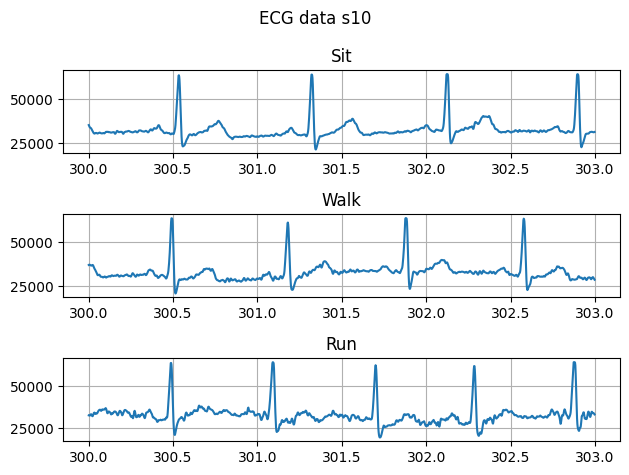

In [5]:


frequency = 500  # Hz

figs, axes = plt.subplots(3, 1)

axes[0].plot(
    sit.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    sit["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[0].set_title("Sit")


axes[1].plot(
    walk.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    walk["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[1].set_title("Walk")


axes[2].plot(
    run.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    run["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[2].set_title("Run")

plt.suptitle(f"ECG data {subject}")


plt.tight_layout()

Para encontrar la evolución de la frecuencia respecto al tiempo y teniendo en cuenta de que no es una señal periodica pura sino quasi periódica 
$$ x(n) \approx x(n + kT), k \in Z $$
$$ |x(n) - x(n + kT)| < \epsilon, k \in Z $$

usaremos la autocorrelación para obtener la separación entre los puntos de maxima similitud de la señal consigo misma.
$$ r_{xx}(l) = \sum^{\infty}_{n=-\infty}x(n).x(n-l) $$

Para esto, se toman ventanas de la señal de 10 segundos, con un solapamiento de 5 segundos. Para cada ventana se le resta su valor promedio, se multiplica por una ventana Hamming y se calcula la autocorrelacion. Luego, encontraremos los máximos locales usando la funcion "find_peaks", que nos entrega los indices de estos máximos. Posteriormente encontramos la diferencia entre esos indices y filtramos esta diferencia a valores razonables de frecuencia cardiaca, debido a que hay armónicos correspondientes a frecuencias mayores a 180 y menores a 60 latidos por segundo que pueden tomar mayor magnitud que el principal debido a la forma de la señal. Luego se toma el promedio de estas diferencias.
Teniendo en cuenta de que la señal original fue muestreada a 500 Hz, se establece que la frecuencia en latidos por minuto es de 
$$ F_{cardiaca} = \frac{60 * 500}{l}$$
Donde $l$ es el promedio de las diferencias de los retrasos donde la autocorrelacion supera un umbral de 0.1.

A continuacion se detalla el código y la gráfica de los resultados obtenidos


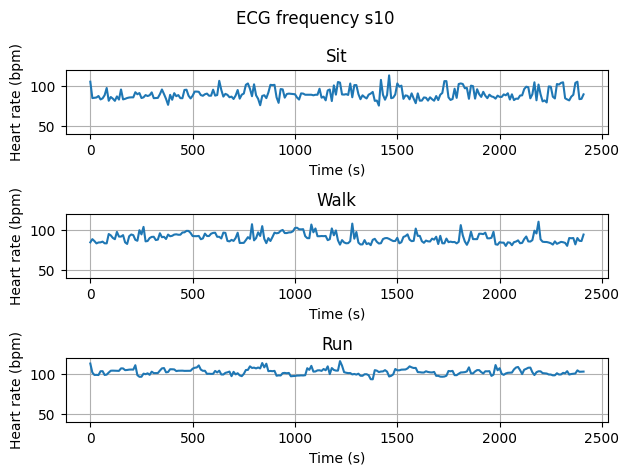

In [6]:
def windowed_auto_correlation_periods(signal, window_size):
    periods = []
    overlap = 0.2
    for i in np.arange(
        0, int(len(signal) - (window_size * overlap)), int(window_size * overlap)
    ):
        window = signal[i  : i + window_size]
        window = window - np.mean(window)
        window = window * np.hamming(len(window))
        auto_correlation = np.correlate(window, window, mode="full")
        auto_correlation = auto_correlation / np.max(auto_correlation)
        auto_correlation = auto_correlation[len(auto_correlation) // 2 :]
        auto_correlation = auto_correlation - np.mean(auto_correlation)
        auto_correlation[np.where(auto_correlation < 0.1)] = 0
        peaks  = find_peaks(auto_correlation, prominence=0.1)[0]  
        
        diff = np.diff(peaks)
        diff = diff[np.where(diff > 250)]
        diff = diff[np.where(diff < 400)]


        if len(diff) == 0:
            periods.append(np.mean(periods))
            continue
        periods.append(
            60 * frequency / np.mean(diff)
        )
    return periods


window = 10  # seconds
run_windowed_auto_correlation = windowed_auto_correlation_periods(
    run["ecg"], window * frequency
)
walk_windowed_auto_correlation = windowed_auto_correlation_periods(
    walk["ecg"], window * frequency
)
sit_windowed_auto_correlation = windowed_auto_correlation_periods(
    sit["ecg"], window * frequency
)

fig, axes = plt.subplots(3, 1)

axes[0].plot(
    window * np.arange(0, len(sit_windowed_auto_correlation)),
    sit_windowed_auto_correlation,
)
axes[0].set_title("Sit")
axes[0].set_ylim(40, 120)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Heart rate (bpm)")
axes[1].plot(
    window * np.arange(0, len(walk_windowed_auto_correlation)),
    walk_windowed_auto_correlation,
)
axes[1].set_title("Walk")
axes[1].set_ylim(40, 120)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Heart rate (bpm)")
axes[2].plot(
    window * np.arange(0, len(run_windowed_auto_correlation)),
    run_windowed_auto_correlation,
)
axes[2].set_title("Run")
axes[2].set_ylim(40, 120)
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Heart rate (bpm)")

plt.suptitle(f"ECG frequency {subject}")
plt.tight_layout()

Como puede observarse, el valor por el que rondan las gráficas incrementa segun la intensidad de la actividad, cuando el sujeto esta sentado, el valor ronda los 85 latidos por minuto, caminando los 90 y corriendo cerca a los 110 latidos por minuto.
Se debe tener especial cuidado con la ventana que se escoge para la señal, ventanas muy pequeñas que no incluyan suficientes periodos de la señal pueden dar resultados inesperados con esta metodología.

Dependiendo de la calidad de las medidas se deberán ajustar los umbrales para la correlación, se observaron casos en que los periodos de la señal no eran tan claros luego de aplicar la correlación debido a la sensibilidad de la metodología a estos parámetros. Como actividad futura se puede plantear un algoritmo apoyado en machine learning que asegure que los parámetros que se ingresan en esas etapas sean adecuados para cada muestra.


## Punto #2

Para este punto se propone analizar el desfase entre 2 señales diferentes, para esto se utiliza la correlación cruzada entre distintos pares de señales, y donde esta correlación sea máxima corresponde al numero de muestras que está "atrasada" o "adelantada" una señal de la otra.
En este punto se analizarán las diferentes combinaciones entre 6 señales:
- egc: Electrocardiograma
- pleth_3: Fotopletismograma con luz verde en el segmento distal del dedo
- pleth_6: Fotopletismograma con luz verde en el segmento proximal del dedo
- lc_1: Pletismograma con sensor de presion en el segmento proximal del dedo
- lc_2: Pletismograma con sensor de presion en el segmento distal del dedo
- temp_1: temperatura medida en el segmento distal del dedo

A continuación se muestran las correlaciones cruzadas para diferentes combinaciones de señales utilizando todo el conjunto de datos.

In [7]:
cross_correlations = {}
columns = ["ecg", "pleth_3", "pleth_6", "lc_1", "lc_2", "temp_1"]


for column_i in columns:
    for column_j in columns:
        if column_i == column_j:
            continue
        if column_j + "_" + column_i in cross_correlations:
            continue
        cross_correlations[column_i + "_" + column_j] = correlate(
            run[column_i] - run[column_i].mean(),
            run[column_j] - run[column_j].mean(),
            mode="full",
        )
        correlation_i = correlate(
            run[column_i] - run[column_i].mean(),
            run[column_i] - run[column_i].mean(),
            mode="full",
        )
        correlation_j = correlate(
            run[column_j] - run[column_j].mean(),
            run[column_j] - run[column_j].mean(),
            mode="full",
        )
        cross_correlations[column_i + "_" + column_j] = cross_correlations[
            column_i + "_" + column_j
        ] / np.sqrt(np.max(correlation_i )*np.max(correlation_j))

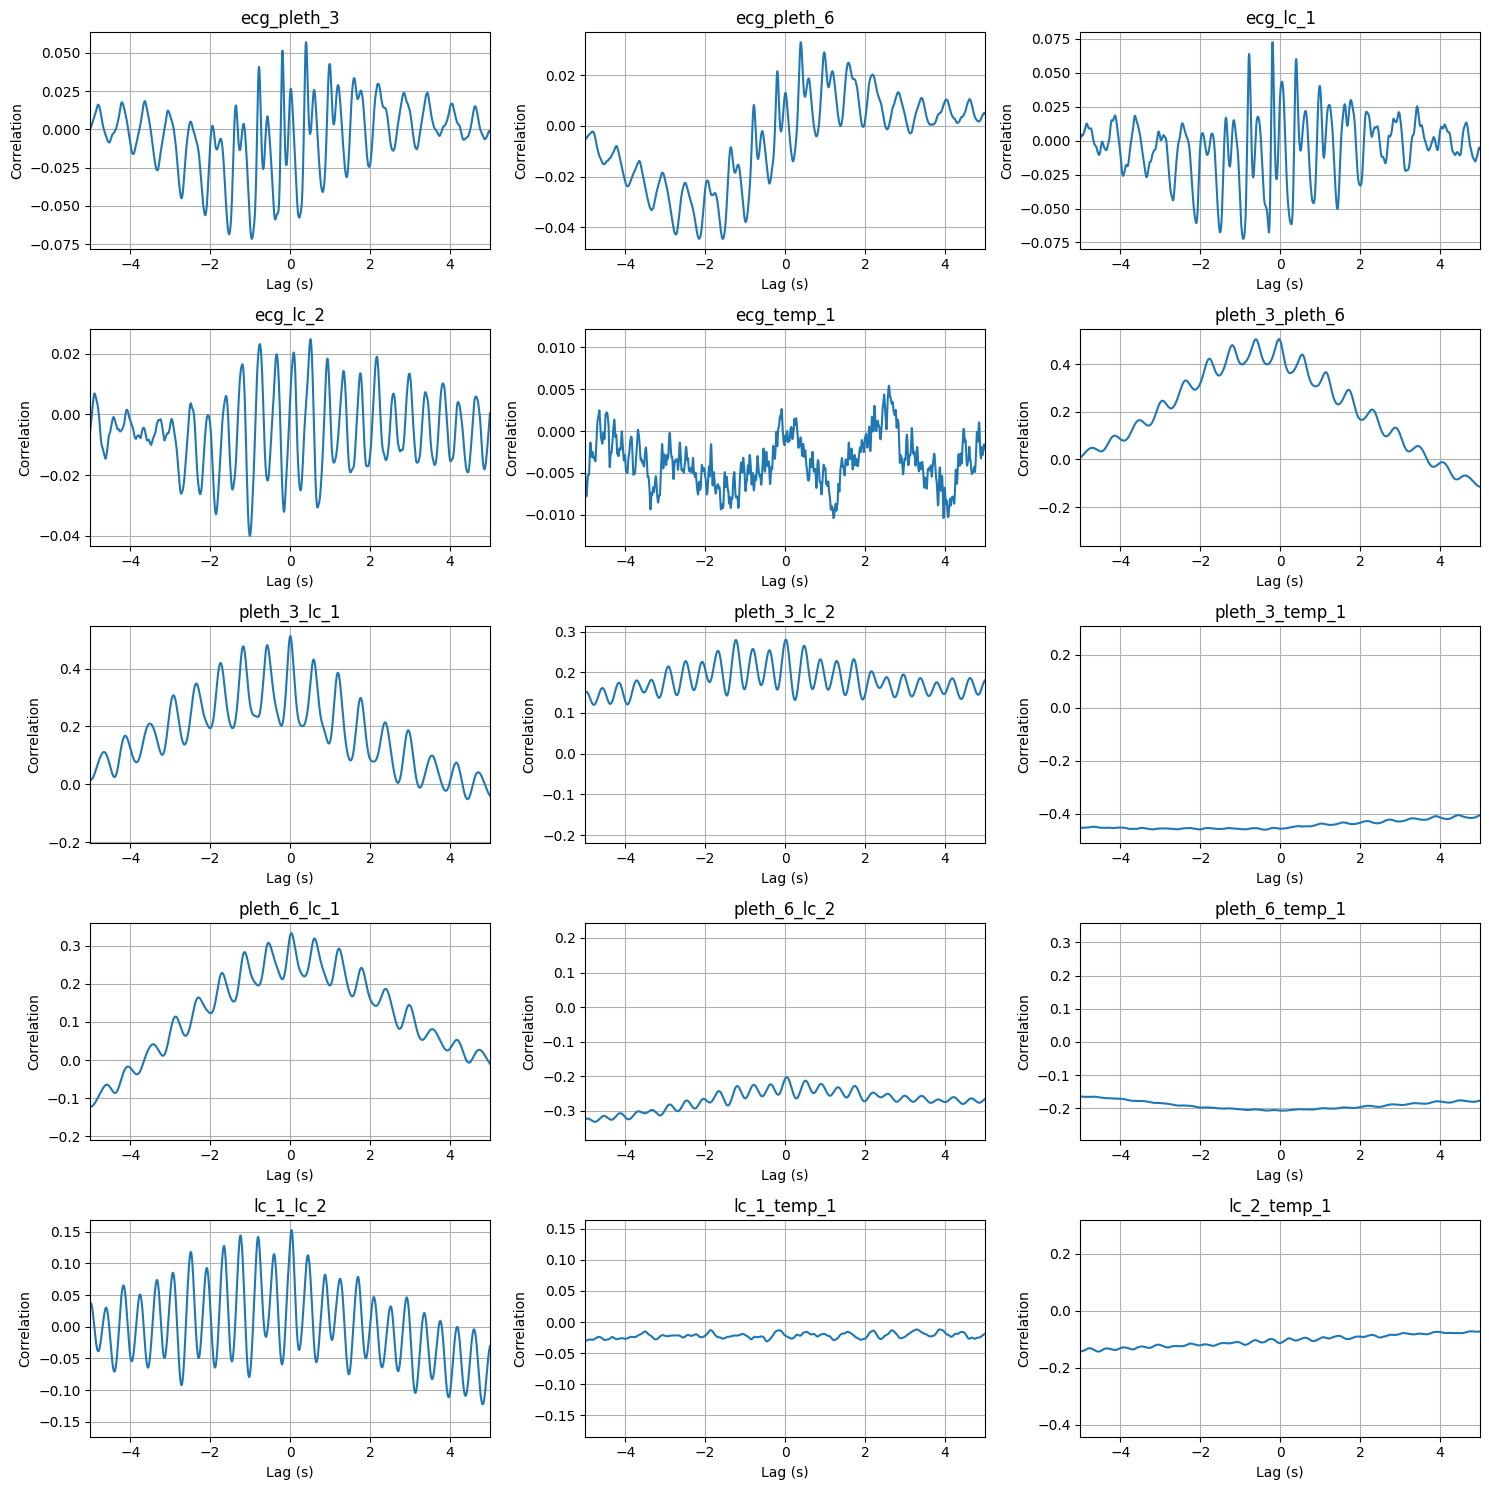

In [8]:
fig, axes = plt.subplots(5,3)
fig.set_figwidth(15)
fig.set_figheight(15)
axes = np.reshape(axes, (-1, 1))
for (key, value), ax in zip(cross_correlations.items(),axes.reshape(-1)):
    i = 0
    x = np.arange(-len(value) // 2, len(value) // 2) / frequency

    ax.plot(x, value, label=key)
    ax.set_title(key)
    ax.set_xlabel("Lag (s)")
    ax.set_ylabel("Correlation")
    ax.set_xlim(-5, 5)
    i += 1
plt.tight_layout()

Compo puede observarse, las formas de la correlacion son bastante diferentes segun el par de señales que se hayan seleccionado.
Si observamos la primera gráfica en la esquina superior izquierda, correspondiente a la correlacion entre egc y pleth_3, se presenta una correlación cuyo valor maximo se encuentra con un retardo diferente de 0, cercano a los 0.3 s.
Si queremos relacionar este retraso con la velocidad a la cual se ve reflejado el latido en la presion sanguinea, podriamos relacionarlo con la longitud del brazo de la siguiente manera:
$$V = \frac{L_{brazo}}{Lag} $$

En otros casos, como por ejemplo en la gráfica inferior derecha, la correlacion entre lc_2 y temp_1 parece indicar que no están muy relacionadas entre si. Esto puede explicarse con la naturaleza de las variables que son representadas por las señales. Por ejemplo, el EGC, la presion, suelen ser variables de cambio muy rápido, y que estan relacionadas fuertemente en el cuerpo, pues son los latidos los que ocasionan el movimiento de la sangre, mientras que la temperatura es de cambio mas lento, y si bien se espera que al haber mayor frecuencia cardiaca por una actividad la tempratura corporal aumente, ambos varían de manera distinta.

Sin embargo, la figura de la esquina superior izquerda parece indicar que hubo un aumento en la presión antes de que el latido ocurriera, presentando un problema de causalidad, por que se espera que el aumento en la presión sea posterior al latido.






A continuación se realizan gráficas del desfase entre las señales a lo largo del tiempo en el cual la similitud es máxima, tomando ventanas de 15 segundos.


In [9]:
def windowed_cross_correlation_lag(signal_1, signal_2, window_size):
    periods = []
    overlap = 0.2
    for i in np.arange(
        0, int(len(signal_1) - (window_size * overlap)), int(window_size * overlap)
    ):
        window_1 = signal_1[i : i + window_size]
        window_1 = window_1 - np.mean(window_1)
        window_2 = signal_2[i : i + window_size]
        window_2 = window_2 - np.mean(window_2)
        window_1 = window_1 * np.hamming(len(window_1))
        window_2 = window_2 * np.hamming(len(window_2))
        auto_correlation_1 = correlate(window_1, window_1, mode="full")
        auto_correlation_2 = correlate(window_2, window_2, mode="full")

        cross_correlation = np.correlate(window_1, window_2, mode="full")/np.sqrt(np.max(auto_correlation_1)*np.max(auto_correlation_2))
        x = np.arange(-len(cross_correlation) // 2, len(cross_correlation) // 2) / frequency
        max_index = x[np.argmax(cross_correlation)]

        periods.append(max_index)
    return periods


cross_correlations_windowed ={}

for column_i in columns:
    for column_j in columns:
        if column_i == column_j:
            continue
        if column_j + "_" + column_i in cross_correlations:
            continue
        cross_correlations_windowed[column_i + "_" + column_j] = windowed_cross_correlation_lag(
            run[column_i] - run[column_i].mean(),
            run[column_j] - run[column_j].mean(),
            15 * frequency,
        )

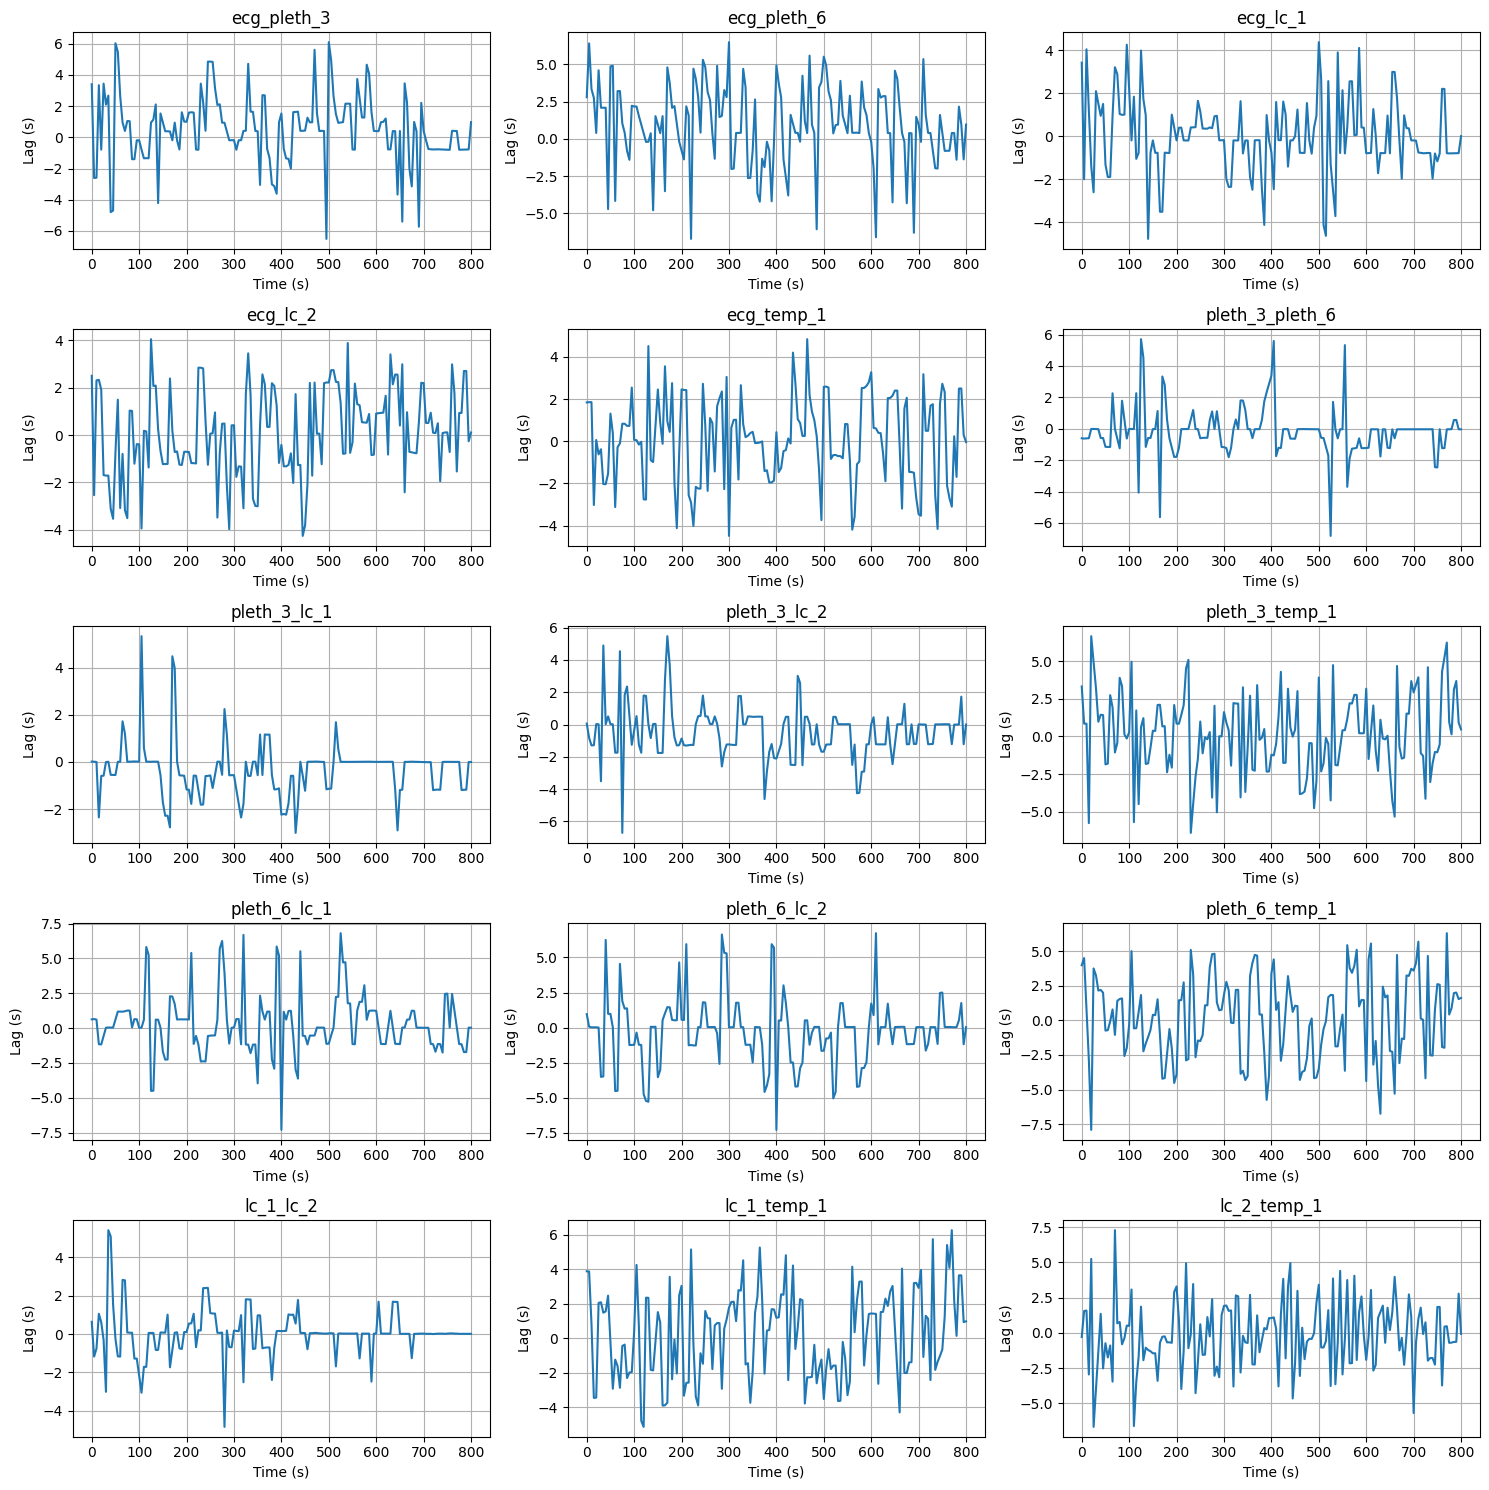

In [10]:
fig, axes = plt.subplots(5, 3)
fig.set_figwidth(15)
fig.set_figheight(15)
axes = np.reshape(axes, (-1, 1))
for (key, value), ax in zip(cross_correlations_windowed.items(), axes.reshape(-1)):
    x = np.arange(0, len(value)) * 5
    ax.plot(x, value, label=key)
    ax.set_title(key)
    ax.set_ylabel("Lag (s)")
    ax.set_xlabel("Time (s)")

plt.tight_layout()

Como se observa en las graficas anteriores, el lag no es constante en el tiempo al utilizar ventanas, sin embargo puede observarse que para algunos pares de señales el lag tiene menos variacion, como por ejemplo en el caso de lc_1 y lc_2.
Este problema puede deberse a la forma que tienen las señales y que los picos no son de la misma forma ni tienen el mismo valor máximo, y esto puede ocasionar que la correlación de en atraso o en adelanto dependiendo de estas magnitudes, por lo que podria sugerirse otro método de análisis, como encontrar los maximos locales de una señal y relacionarlos con los máximos locales de la otra señal y encontrar el desfase entre ellos.

Se debe tener en cuenta que la calidad de los datos no es adecuada en varias ocasiones como se evidenciará posteriormente, esto puede ocasionarse por problemas con los sensores y su ubicación, ademas, como se observa en las descripciones hechas por los autores, algunas variables se muestrean con una frecuencia diferente, indicando que se utilizó algun metodo para llenar los valores intermedios de esas variables con menor tasa de muestreo. 
Estas situaciones pueden ser las causantes de los problemas de la estimación del desfase donde la correlacion es máxima.


## Punto número 3

Para esta actividad se propone utilizar un modelo de clasificador, que con ciertas características de las señales de cada dataset pueda clasificar cada conjunto de datos en uno tipo de actividad, ya sea estar sentado, caminando o corriendo.
Para esto se utilizan todos los conjuntos de datos de los 22 pacientes y se extraen algunas características de las señales, como el promedio de la temperatura, la frecuencia cardiaca, el promedio de la acelerometría.


In [11]:


def calcular_fc(ecg_signal, fs, label):

    ecg_signal_normalizada = ecg_signal - np.mean(ecg_signal)
    ecg_signal_normalizada = ecg_signal_normalizada / np.max(ecg_signal_normalizada)
    peaks, _ = find_peaks(ecg_signal_normalizada, height=0.6)  


    intervalo_entre_picos = np.diff(peaks) / fs
    intervalo_entre_picos = intervalo_entre_picos[1 / intervalo_entre_picos < 3.33]
    intervalo_entre_picos = intervalo_entre_picos[1/intervalo_entre_picos > 0.8]

    fc = 60 / np.mean(intervalo_entre_picos)

    return fc



def calculate_frequency(ecg_signal: ndarray[Any, dtype[floating[_64Bit]]], fs: int) -> float:

    ecg_signal_normalized = ecg_signal - np.mean(ecg_signal)
    ecg_signal_normalized = ecg_signal_normalized / np.max(ecg_signal_normalized)
    freq: ndarray[Any, dtype[floating[_64Bit]]] = np.fft.fftfreq(
        len(ecg_signal_normalized), 1 / fs
    )
    ecg_signal_normalized = fft(ecg_signal_normalized)
    ecg_signal_normalized: ndarray[Any, dtype[Any]] = np.abs(ecg_signal_normalized)
    ecg_signal_normalized = ecg_signal_normalized / np.max(ecg_signal_normalized)
    max_freq = freq[np.argmax(ecg_signal_normalized)]

    return max_freq


subjects_data = pd.read_csv("data/subjects_info.csv")
files = glob.glob("data/s*.csv")
data = []
for file in files:
    try:

        activity = file.split("/")[-1].split("_")[1].split(".")[0]
        data_file: pd.DataFrame = pd.read_csv(file)
        data.append(
            {
                "subject": file.split("/")[-1].split("_")[0],
                "weight": subjects_data[
                    subjects_data["record"] == file.split("/")[-1].split(".")[0]
                ]["weight"].values[0],
                "height": subjects_data[
                    subjects_data["record"] == file.split("/")[-1].split(".")[0]
                ]["height"].values[0],
                "age": subjects_data[
                    subjects_data["record"] == file.split("/")[-1].split(".")[0]
                ]["age"].values[0],
                "activity": activity,
                "ecg_frequency": calcular_fc(
                    data_file["ecg"][1 * 60 * frequency : (1 * 60 + 5) * frequency],
                    frequency, file.split("/")[-1].split(".")[0]
                ),
                "temp_1_mean": data_file["temp_1"].mean(),
                "a_y_mean": abs(data_file["a_y"].mean()),
                # "temp_2_mean": data_file["temp_2"].mean(),
                # "pleth_3_mean": data_file["pleth_3"].mean(),
                # "pleth_6_mean": data_file["pleth_6"].mean(),
                # "lc_1_mean": data_file["lc_1"].mean(),
                # "lc_2_mean": data_file["lc_2"].mean(),
            }
        )
    except Exception as e:
        print(e)
        print(file)


data = pd.DataFrame(data)
data.head()

index 0 is out of bounds for axis 0 with size 0
data/subjects_info.csv


,subject,weight,height,age,activity,ecg_frequency,temp_1_mean,a_y_mean
0,s15,65,170,20,sit,74.850299,30.077455,6.298108
1,s7,80,175,30,sit,65.466448,33.540141,5.270146
2,s12,80,185,25,sit,71.394574,34.430727,1.587142
3,s9,70,175,20,run,74.962519,27.796214,4.617645
4,s8,75,175,50,run,74.906367,33.176469,2.360326


Para los clasificadores se utilizarán los siguientes tipos
- Maquina de soporte vectorial
- Decision Tree
- Clasificador de Bayes
- Closest Neighbor
- Random Forest
- Perceptron multicapa

Para empezar dividiremos los datos seleccionando las columnas de entrada y la salida (que corresponde a la actividad de cada dataset)
Para el set de entrenamiento dividiremos el conjunto de datos d emanera aleatoria y se entrenara con un 80% de los datos y se probará el modelo con el 20% restante

In [18]:
y = data["activity"]
X = data.drop(columns=["activity", "subject", "height", "weight", "age"])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Para todos los clasificadores se utiliza la siguiente metodología:
- Se instancia el clasificador utilizando el correspondiente constructor
- Se entrena el modelo con el método fit y los datos de entrenamiento seleccionados
- Se predice la salida utilizando los datos de entrada seleccionados para probar con el método predict
- Se extrae un reporte de clasificacion y una matriz de confusión 

Los resultados para cada modelo son los siguientes:

In [25]:
plt.rcParams["axes.grid"] = False

### Máquina de soporte vectorial

              precision    recall  f1-score   support

         run       0.71      0.83      0.77         6
         sit       1.00      1.00      1.00         4
        walk       0.67      0.50      0.57         4

    accuracy                           0.79        14
   macro avg       0.79      0.78      0.78        14
weighted avg       0.78      0.79      0.78        14



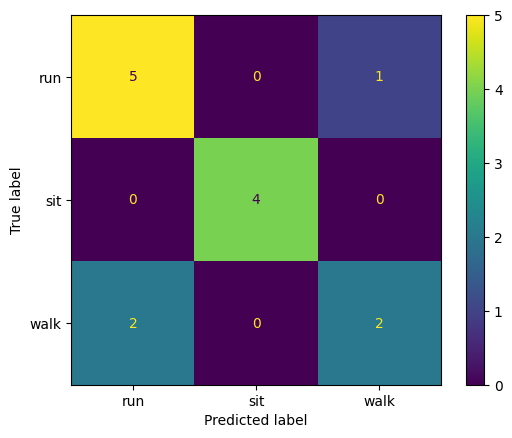

In [34]:
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))
cm = confusion_matrix(y_test, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()

### Arbol de decisión

              precision    recall  f1-score   support

         run       0.83      0.83      0.83         6
         sit       0.80      1.00      0.89         4
        walk       0.67      0.50      0.57         4

    accuracy                           0.79        14
   macro avg       0.77      0.78      0.76        14
weighted avg       0.78      0.79      0.77        14



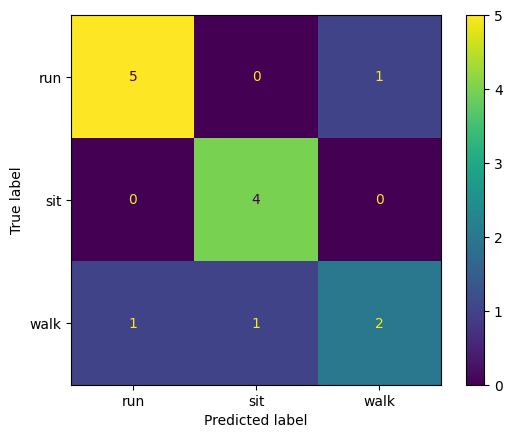

In [35]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print(classification_report(y_test, y_pred_tree))
cm = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree.classes_)
disp.plot()

### Clasificador de Bayes

              precision    recall  f1-score   support

         run       0.83      0.83      0.83         6
         sit       0.50      0.25      0.33         4
        walk       0.33      0.50      0.40         4

    accuracy                           0.57        14
   macro avg       0.56      0.53      0.52        14
weighted avg       0.60      0.57      0.57        14



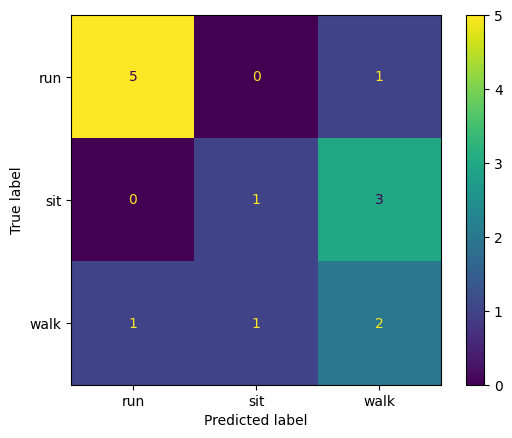

In [36]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
y_pred_bayes = bayes.predict(X_test)
print(classification_report(y_test, y_pred_bayes))
cm = confusion_matrix(y_test, y_pred_bayes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bayes.classes_)
disp.plot()

### Closest Neighbor

              precision    recall  f1-score   support

         run       0.83      0.83      0.83         6
         sit       0.80      1.00      0.89         4
        walk       0.67      0.50      0.57         4

    accuracy                           0.79        14
   macro avg       0.77      0.78      0.76        14
weighted avg       0.78      0.79      0.77        14



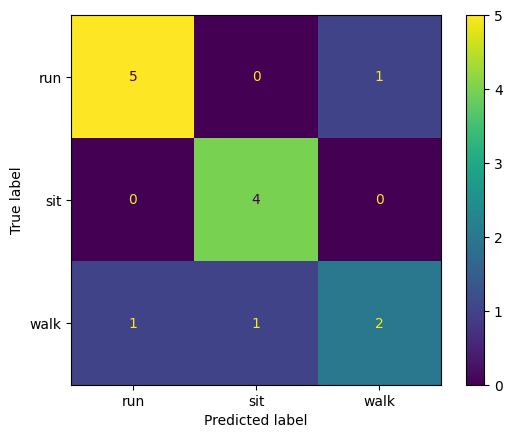

In [37]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

### Random Forest

              precision    recall  f1-score   support

         run       0.71      0.83      0.77         6
         sit       1.00      1.00      1.00         4
        walk       0.67      0.50      0.57         4

    accuracy                           0.79        14
   macro avg       0.79      0.78      0.78        14
weighted avg       0.78      0.79      0.78        14



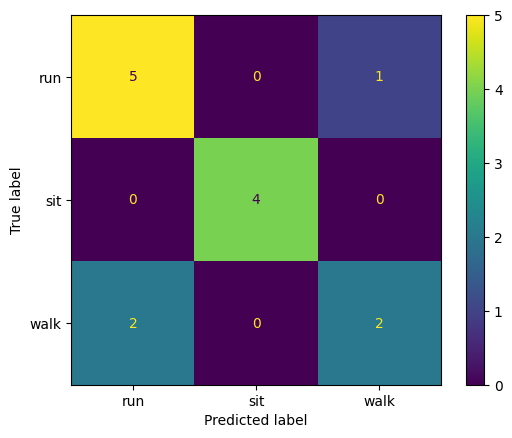

In [38]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
print(classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest.classes_)
disp.plot()

### Perceptrón multicapa

              precision    recall  f1-score   support

         run       0.83      0.83      0.83         6
         sit       1.00      1.00      1.00         4
        walk       0.75      0.75      0.75         4

    accuracy                           0.86        14
   macro avg       0.86      0.86      0.86        14
weighted avg       0.86      0.86      0.86        14



/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


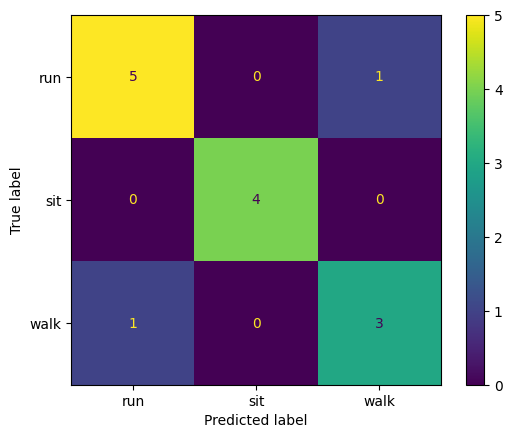

In [40]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation="relu", alpha=0.01)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print(classification_report(y_test, y_pred_mlp))
cm = confusion_matrix(y_test, y_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot()

### Resumen de métricas

In [43]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, f1_score



print("1. Bayes: ")
print("Accuracy: ", round(balanced_accuracy_score(y_test, y_pred_bayes), 2))
print("kappa: ", round(cohen_kappa_score(y_test, y_pred_bayes), 2))
print("f1: ", round(f1_score(y_test, y_pred_bayes, average="weighted"), 2))
print("--")
print("2. KNN: ")
print("Accuracy: ", round(balanced_accuracy_score(y_test, y_pred_knn), 2))
print("kappa: ", round(cohen_kappa_score(y_test, y_pred_knn), 2))
print("f1: ", round(f1_score(y_test, y_pred_knn, average="weighted"), 2))
print("--")
print("3. SVM: ")
print("Accuracy: ", round(balanced_accuracy_score(y_test, y_pred_svc), 2))
print("kappa: ", round(cohen_kappa_score(y_test, y_pred_svc), 2))
print("f1: ", round(f1_score(y_test, y_pred_svc, average="weighted"), 2))
print("--")
print("4. Decision Tree: ")
print("Accuracy: ", round(balanced_accuracy_score(y_test, y_pred_tree), 2))
print("kappa: ", round(cohen_kappa_score(y_test, y_pred_tree), 2))
print("f1: ", round(f1_score(y_test, y_pred_tree, average="weighted"), 2))
print("--")
print("5. MLP: ")
print("Accuracy: ", round(balanced_accuracy_score(y_test, y_pred_mlp), 2))
print("kappa: ", round(cohen_kappa_score(y_test, y_pred_mlp), 2))
print("f1: ", round(f1_score(y_test, y_pred_mlp, average="weighted"), 2))
print("--")
print("6. Ranfom Forest: ")
print("Accuracy: ", round(balanced_accuracy_score(y_test, y_pred_rf), 2))
print("kappa: ", round(cohen_kappa_score(y_test, y_pred_rf), 2))
print("f1: ", round(f1_score(y_test, y_pred_rf, average="weighted"), 2))

1. Bayes: 
Accuracy:  0.53
kappa:  0.34
f1:  0.57
--
2. KNN: 
Accuracy:  0.78
kappa:  0.67
f1:  0.77
--
3. SVM: 
Accuracy:  0.78
kappa:  0.67
f1:  0.78
--
4. Decision Tree: 
Accuracy:  0.78
kappa:  0.67
f1:  0.77
--
5. MLP: 
Accuracy:  0.86
kappa:  0.78
f1:  0.86
--
6. Ranfom Forest: 
Accuracy:  0.78
kappa:  0.67
f1:  0.78


Como puede observarse, dependiendo del tipo de modelo se obtienen distintos desempeños con el mismo set de datos.
El modelo de menor desempeño es el clasificador de Bayes, posiblemente su bajo desempeño se debe a que está basado en funciones de distribución a las cuales se les estiman sus parámetros, y no se basa en las instancias que se estan ingresando como si lo hacen los demás modelos.
Por otro lado, todos los demas modelos obtuvieron un score f1 mayor a 0.7, lo que indica que pueden identificar tanto los casos positivos como los negativos sin darle mucha prioridad a una clase que se presente mayoritariamente, además con un kappa mayor a 0.6 indica que los resultados no son resultado del azar y que sugieren una buena concordancia con lo que esperaria un clasificador humano. 

## Problemas encontrados a lo largo del desarrollo del taller

El principal problema encontrado en el desarrollo de la practica era la calidad de algunas de las señales, por ejemplo se encontraron señales de muy buena calidad como la siguiente

![señal de buena calidad](assets/output4.png "Señal de buena calidad")

Sin embargo este no es el caso para todas las señales, pueden presentarse irregularidades donde hayan picos que dificulten los procesos de correlacion

![señal irregular](assets/output2.png "Señal irregular")

Pueden presentarse formas extrañas en la onda que al normalizarla desplazan la imagen muy por debajo del 0

![señal irregular](assets/output.png "Señal irregular")

Y en ocasiones hay problemas mas graves con la señal que hacen que sea practicamente inutilizable

![señal con problemas graves](assets/output3.png "Señal irregular")

Esto representa problemas especialmente cuando se realiza la correlación con 2 señales diferentes para analizar el desfase entre ellas, el desfase puede dar un valor erroneo cuando la ventana de los datos se reduce a un momento en el cual suceden estas irregularidades y picos anormales en las medidas.
Estas irregularidades pueden deberse a problemas en la medicion o en los equipos de medicion, posiblemente en algunos casos como en la ultima imagen el sensor no estaba bien asegurado o hubo alguna interferencia externa, ocasionando que la señal sea erronea.

Ademas de esto, las condiciones de cada persona son considerablemente diferentes teniendo en cuenta su preparación fisica, posibles enfermedades, edad, y características fisicas. Dos personas similares de la misma edad y características físicas pueden obtener resultados completamente diferentes, lo que dificulta que los modelos entreguen un resultado acertado con tan pocos casos. 
